In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sta tsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf
from itertools import product
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

link to a file: "https://drive.google.com/file/d/1VUxFSgT0MrT_OXXYRTcC43d07WKrPYJg/view?usp=drive_link"
name: 'h7_data.csv'

In [8]:
data = pd.read_csv('h7_data.csv')
data.head()

,year,ppmv
0,1959,316.00
1,1960,316.91
2,1961,317.63
3,1962,318.46
4,1963,319.02


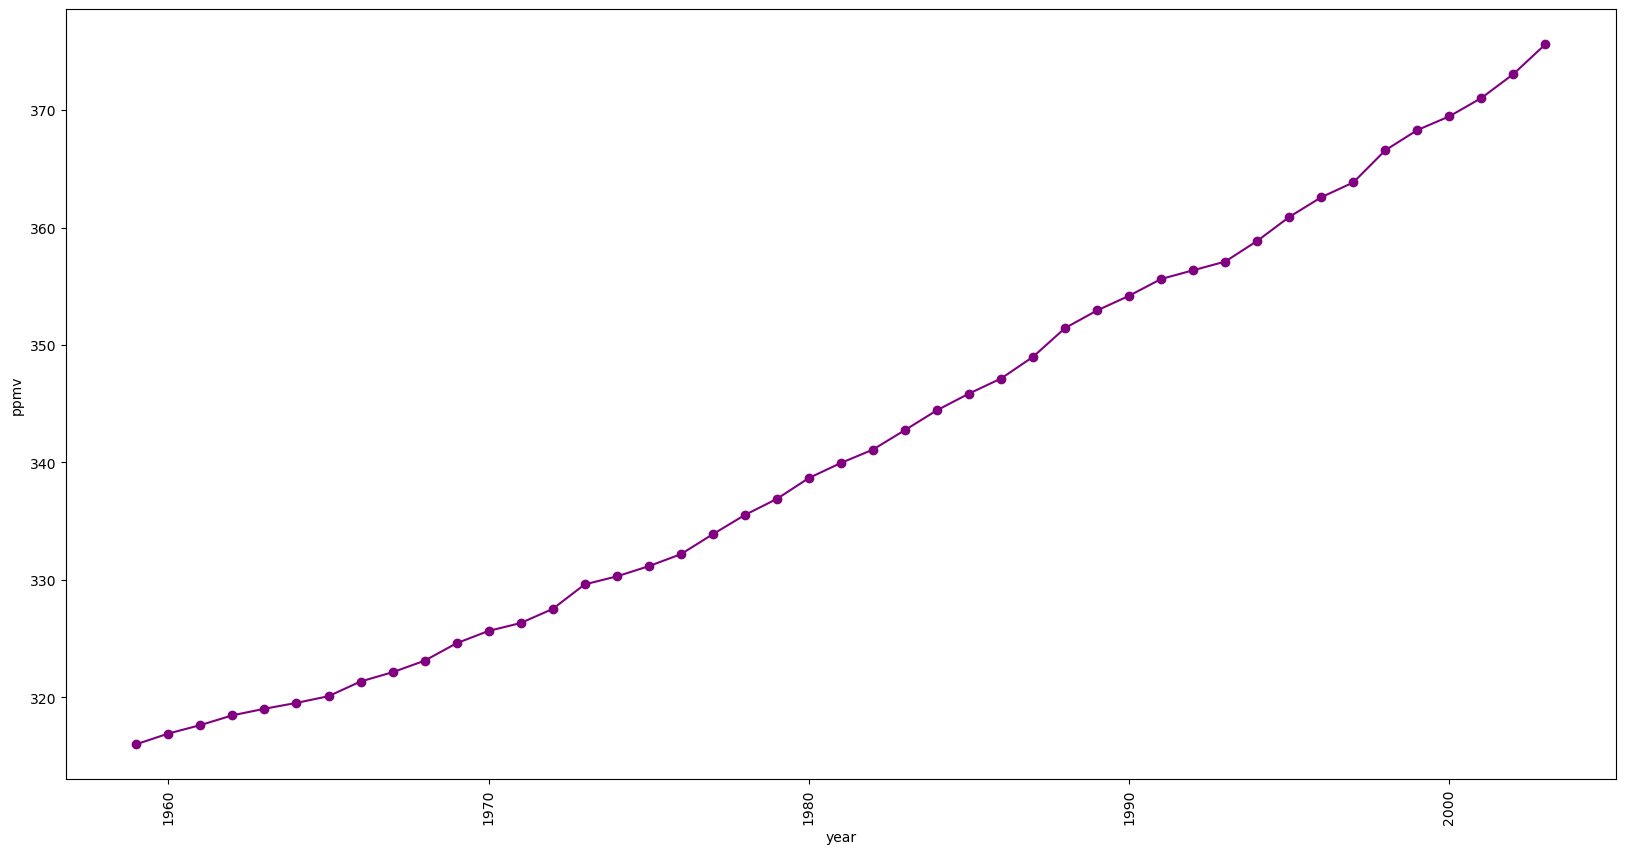

In [10]:
#plot the data
fig = plt.figure(figsize=(20, 10))
plt.scatter(data['year'], data['ppmv'], color = 'purple')
plt.plot(data['year'], data['ppmv'], '-', color = 'purple')
plt.xlabel('year')
plt.ylabel('ppmv')

# Set the tick locations and labels on the x-axis
plt.xticks(rotation = 90)
plt.show()

In [13]:
#Run the ADF test and check if the process is stationary. If not, apply differencing.
ADF_result = adfuller(data['ppmv'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: 3.816548025237228
p-value: 1.0


As it is seen from the ADF test, the p-value is bigger than 0.05, which means that the process is not stationary and we have to apply differencing

In [27]:
differenced = data['ppmv'] - data['ppmv'].shift(1)
data['diff'] = differenced
data = data.dropna()

In [29]:
#checking stationarity after applying differencing
ADF_result = adfuller(data['diff'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -3.3237545218120332
p-value: 0.013849467549477178


It's now seen that the p-value is less than 0.05 which means that the process is now stationary and we can continue working.

In [31]:
#Separate your series into a train set and a test set
train_size = int(len(data) * 0.8) 
train = data[:train_size]
test = data[train_size:]

In [219]:
#Define a range of values for p and q, and generate combinations of orders (p, q).
#plot_acf(data['diff'], lags=20)
#plot_pacf(data['diff'], lags=20)
from itertools import product
ps = range(0, 5, 1)
qs = range(0, 5, 1)
order_list = list(product(ps, qs))

In [220]:
#Select the best model according to the AIC, and store the residuals in a variable.
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
     #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [221]:
#Select the best model according to the AIC, and store the residuals in a variable.
results_df = optimize_ARMA(train, order_list)

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An u

ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements

In [222]:
#the results we got
results_df

,"(p,q)",AIC
0,"(3, 0)",49.577171
1,"(3, 1)",49.591522
2,"(2, 3)",49.811983
3,"(1, 3)",49.838109
4,"(3, 3)",49.917974
5,"(1, 2)",50.085204
6,"(1, 1)",50.256736
7,"(2, 2)",50.297812
8,"(3, 2)",51.316774
9,"(1, 0)",57.825735


In [227]:
#Select the best model according to the AIC, and store the residuals in a variable.
best = results_df['(p,q)'].iloc[0]
best_order = [best[0], 0, best[1]]
model = SARIMAX(train['diff'], order=best_order, simple_differencing=False).fit(disp=False)

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


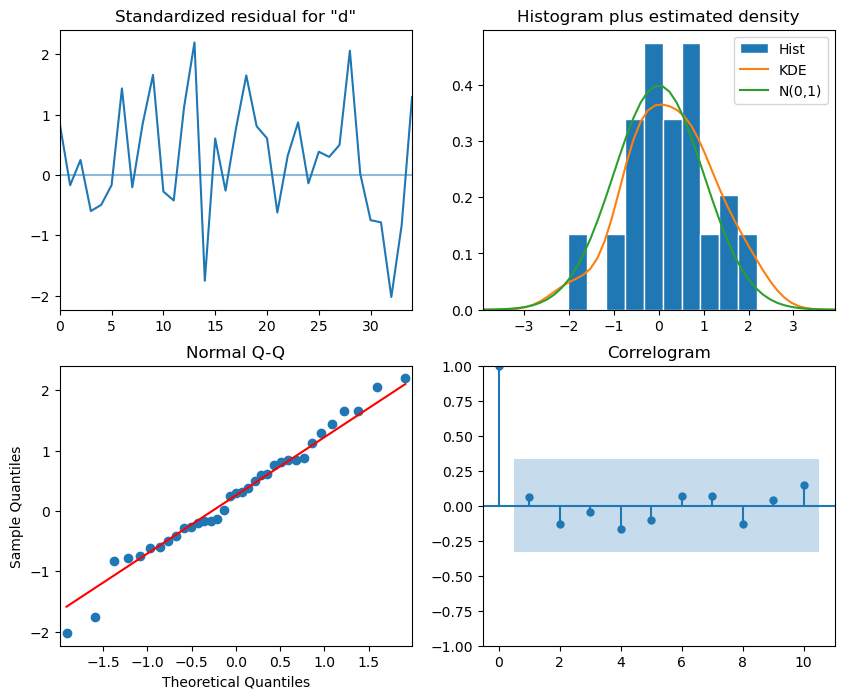

In [200]:
#Perform a qualitative analysis of the residuals with the plot_diagnostics method. Does
#the Q-Q plot show a straight line that lies on y = x?
model.plot_diagnostics(figsize=(10, 8))
plt.show()

As we can see Q-Q show almost a straight line that lies on y = x

In [201]:
#Perform a quantitative analysis of the residuals by applying the Ljung-Box test on the
#first 10 lags. Are all returned p-values above 0.05? Are the residuals correlated or not?
import statsmodels.api as sm
residuals = model.resid
lb_test = sm.stats.acorr_ljungbox(residuals, lags=10)

In [202]:
lb_test

,lb_stat,lb_pvalue
1,0.033028,0.855789
2,0.520246,0.770957
3,0.767948,0.857117
4,2.074317,0.722092
5,2.707746,0.744933
6,3.217819,0.781053
7,3.328678,0.853025
8,3.859696,0.869555
9,4.240841,0.894858
10,4.790192,0.904745


As we can see all returned p-values are above 0.05 which means that the residuals are not correlated

In [203]:
pred_mean = [] 
df_diff = data['diff']
for i in range(len(train), len(data), 2):
    mean = np.mean(df_diff[:i].values)
    pred_mean.extend(mean for _ in range(2))
preds_mean = pred_mean[0:9]

In [205]:
pred_last_value = []
for i in range(len(train), len(data), 2):
    last_value = df_diff[:i].iloc[-1]
    pred_last_value.extend([last_value] * 2)
pred_last_value = pred_last_value[0:9]

In [233]:
# Make predictions using the selected ARMA(p, q) model, mean method, and last known value method
pred_AR = []
for i in range(len(train), len(data)+1, 2):
    model = SARIMAX(df_diff[:i], order=(3,0,0))
    res = model.fit(disp=False)
    predictions = res.get_prediction(0, i + 1)
    oos_pred = predictions.predicted_mean.iloc[-2:]
    pred_AR.extend(oos_pred)
pred_AR = pred_AR[0:9]

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471:

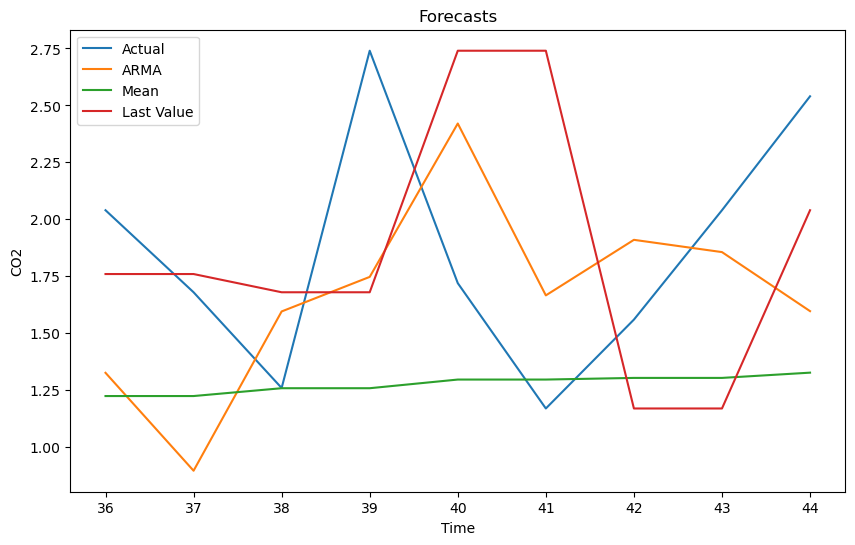

In [237]:
# Plot the forecasts
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['diff'], label='Actual')
plt.plot(test.index, pred_AR, label='ARMA')
plt.plot(test.index, preds_mean, label='Mean')
plt.plot(test.index, pred_last_value, label='Last Value')
plt.xlabel('Time')
plt.ylabel('CO2')
plt.title('Forecasts')
plt.legend()
plt.show()

In [238]:
#Evaluate each method’s performance using the MSE. Which method performed best?
mse_arma = mean_squared_error(test['diff'], predictions_arma)
mse_mean = mean_squared_error(test['diff'], preds_mean)
mse_last_value = mean_squared_error(test['diff'], pred_last_value)

print("MSE - ARMA:", mse_arma)
print("MSE - Mean:", mse_mean)
print("MSE - Last Value:", mse_last_value)

MSE - ARMA: 0.4261177397047209
MSE - Mean: 0.5932053115864284
MSE - Last Value: 0.6721222222222105


ARMA gives the smallest mse

In [260]:
#Reverse differencing, plot the best forecast and calculate the MAE.
rev_pred = data['ppmv'].iloc[len(train)] + np.array(pred_AR).cumsum()
mae_AR_undiff = mean_absolute_error(data['ppmv'][len(train):], rev_pred)
print("MAE - ARMA:", mae_AR_undiff)

MAE - ARMA: 0.8360085188110007


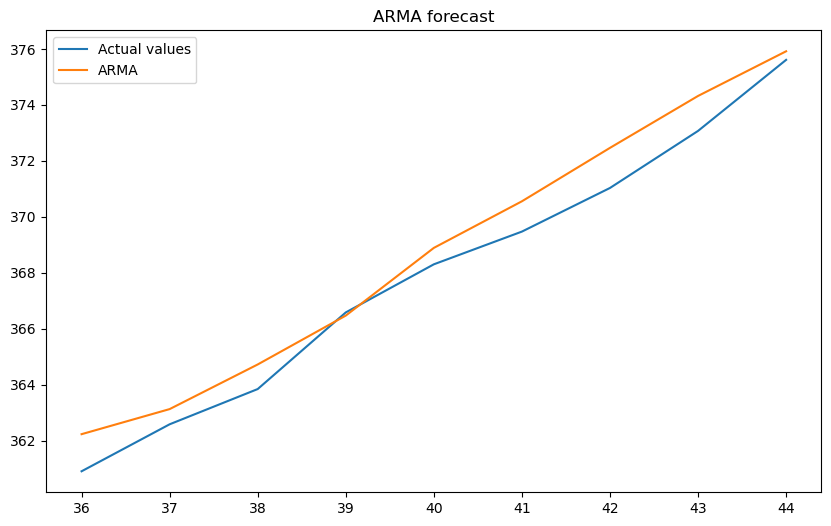

In [265]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['ppmv'], label='Actual values')
plt.plot(test.index, rev_pred, label='ARMA')
plt.title('ARMA forecast')
plt.legend()
plt.show()